# CNN을 사용한 Fashion mnist 분류

CNN을 사용해서 Fashion mnist를 분류 해보자. mnist의 기초에는 숫자도 있으며 이번에는 옷을 인식하고 분류 해보려 한다.

### 0. Library

라이브러리는 pandas, numpy, tensorflow, matplotlib, seaborn, keras, sklearn을 기본적으로 사용한다. 또한, 환경은 GPU를 사용할 수 있는 Google Colab 노트북에서 진행 한다. 

In [2]:
import sys
import os

import pandas as pd
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import seaborn as sns

from keras.callbacks import ModelCheckpoint, EarlyStopping
from keras.datasets import mnist
from keras.utils import np_utils
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPooling2D

from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split
from IPython.display import Image

for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

### 1. Data

우선 데이터를 불러오자. 그리고 label에 따라 X_train, Y_train으로 분류 해준다.

In [3]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [ ]:
# Load the data

train = pd.read_csv("gdrive/MyDrive/Colab Notebooks/Dacon/Fashion_MNIST/train.csv")
test = pd.read_csv("gdrive/MyDrive/Colab Notebooks/Dacon/Fashion_MNIST/test.csv")

X_train = train.drop(["index","label"],axis=1)
Y_train = train['label']

test_index = test['index']
test = test.drop(['index'], 1)

pandas로 불러온 데이터는 reshape함수를 통해 28 * 28배열로 변환 시켜 준다.|

In [ ]:
X_train = X_train.values.reshape(-1,28,28,1)
test = test.values.reshape(-1,28,28,1)

### 2. 데이터 파악

10개의 class로 나눠져 있으며 각 번호에 대한 정보는 다음과 같다.

- 0: T-shirt/top
- 1: Trouser
- 2: Pullover
- 3: Dress
- 4: Coat
- 5: Sandal
- 6: Shirt
- 7: Sneaker
- 8: Bag
- 9: Ankle boot


추가로 각각의 이미지는 다음과 같다.

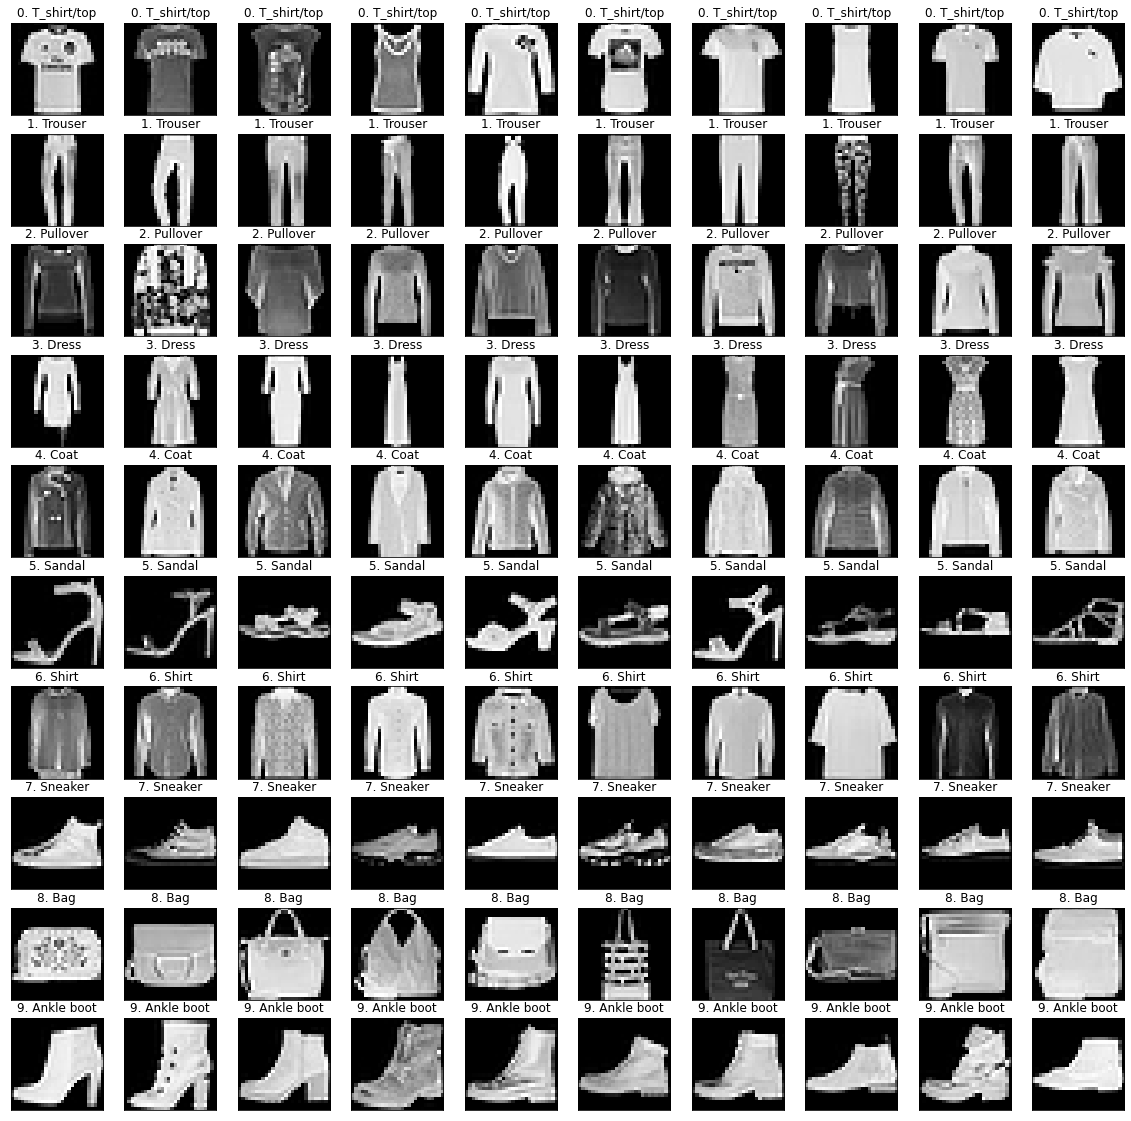

In [ ]:
class_names = ['T_shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat', 
               'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot']

plt.figure(figsize=(20, 20))
for k in range(10):
  XX = X_train[Y_train == k]
  YY = Y_train[Y_train == k].reset_index()['label']
  for i in range(10):
    plt.subplot(10, 10, k*10 + i + 1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(XX[i][:,:,0], cmap='gray')
    label_index = int(YY[i])
    plt.title('{}. {}'.format(k, class_names[label_index]))
plt.show()

### 3. Train/test set 분류

sklearn의 model_selection에서 train_test_split 함수를 불러온 후, train set과 validation set으로 분리 시켜주자. train/val의 비율은 8:2로 test_size옵션에서 0.2를 사용 해주었다. 추가로 randaom_state=100으로 해주어, seed를 100으로 지정 해주었다. 다음에 사용된 라이브러리는 다음과 같다.

- from sklearn.model_selection import train_test_split

In [ ]:
X_train, X_val, Y_train, Y_val = train_test_split(X_train, 
                                                  Y_train, 
                                                  test_size = 0.2, 
                                                  random_state=100)

이렇게 10000개의 이미지 데이터중 8000개와 2000개로 분리 시켜주었다.

In [ ]:
print("Train set 이미지 수: {} 개".format(X_train.shape[0]))
print("Validation set 이미지 수: {} 개".format(X_val.shape[0]))

Train set 이미지 수: 8000 개
Validation set 이미지 수: 2000 개


#### 3-1. 전처리

- X
    - 이제 이 데이터를 255로 나누어 주자. 0에서 255의 숫자의 배열로 이루어진 이미지 데이터를 255로 나누어 주어 0~1로 변환 사켜주는 작업이다. 케라스는 데이터를 0에서 1 사이의 값으로 변환한 다음 구동할 때 최적의 성능을 보이기 때문이다. 따라서 astype()함수를 통해 실수형으로 바꿔준 후 255로 나누는 작업을 진행 했다.
- Y
    - Y의 경우에는 원-핫 인코딩을 적용해주자. np_utils.to_categorical()함수를 사용한다. 활성화 함수를 사용하기 위해서는 Y값이 0과 1로 이루어져야 하기 때문인데 이는 5라는 라벨을 갖고 있는 데이터를 array([0.,0.,0.,0.,1.,0.,0.,0.,0.]) 로 바꿔준다.

In [ ]:
# CNN
X_train = X_train.reshape(X_train.shape[0], 28, 28, 1).astype('float32') / 255
X_val = X_val.reshape(X_val.shape[0], 28, 28, 1).astype('float32') / 255

Y_train = np_utils.to_categorical(Y_train)
Y_val = np_utils.to_categorical(Y_val)

### 4. 모델

#### 4-1. 모델 설계

모델을 만들어보자. 우선 model.Sequential()한수를 사용하여 model을 선언 해주고 model.add()를 사용하여 차곡차곡 하나씩 층을 만들어 주려고 한다. 다음을 보자.


**a. Convolution층**

케라스에서 Convolution층을 추가하는 함수는 Conv2D()이다.

- model.add(Conv2D(32, kernel_size = (3,3), input_shape=(28,28,1), activation='relu'))
    - 32: 32개의 mask를 사용
    - kernel_size: (3,3)의 커널을 정한다. 
    - input_shape: (28,28,1)
    - activation: 활성화 함수를 relu로 정해준다.
- model.add(Conv2D(64,(3,3), activation='relu'))
    -  mask 64를 적용한 새로운 Convolution층을 하나 더 추가한다.

**b. Maxpooling**

이제 추가로 Maxpooling 층울 추가 하보자. convolution으로 층을 추가 했지만 여전히 크기 때문에 한번 더 축소를 진행 한다.

- model.add(MaxPooling2D(pool_size=2))
    - pool_size: pooling창의 크기를 정하는 것으로 2로 정하여 줄여 주었다.
    
**c. Drop out & Flatten**

- model.add(Dropout(0.25))
    - 딥러닝을 학습할때 과적합을 효과적으로 피해가는 방법중 다음의 기법이 있다. drop out기법인데, 이는 은닉층에 배치된 노드 중 일부를 임의로 껴주는 것이다.

- model.add(Flatten())
    - convolution이나 max pooling는 2차원 배열인 채로 다루는데, 이를 1차원으로 바꿔주자.

In [ ]:
# 컨볼루션 신경망 설정
model = Sequential()

model.add(Conv2D(32, kernel_size = (3,3), input_shape=(28,28,1), activation='relu'))
model.add(Conv2D(64,(3,3), activation='relu'))
model.add(MaxPooling2D(pool_size=2))
model.add(Dropout(0.25))
model.add(Flatten())
model.add(Dense(128, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(10, activation='softmax'))

모델 summary를 보자.

In [ ]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 26, 26, 32)        320       
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 24, 24, 64)        18496     
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 12, 12, 64)        0         
_________________________________________________________________
dropout (Dropout)            (None, 12, 12, 64)        0         
_________________________________________________________________
flatten (Flatten)            (None, 9216)              0         
_________________________________________________________________
dense (Dense)                (None, 128)               1179776   
_________________________________________________________________
dropout_1 (Dropout)          (None, 128)               0

#### 4-2. 모델 컴파일

모델을 컴파일 해보자. 오차 함수로cetegorical_crossentropy, 최적화 함수로 adam을 사용한다.

In [ ]:
model.compile(loss = 'categorical_crossentropy',
              optimizer='adam',
              metrics = ['accuracy'])

#### 4-3. 모델 최적화 설정

이제 모델의 성과를 저장하고 모델의 최적화 단계에서 학습을 중단하게끔 설정 해주자. 이는 10회 이상 모델의 성과 향상이 없으면 자동으로 학습을 중단하게 된다.

In [ ]:
MODEL_DIR = "./model/"

if not os.path.exists(MODEL_DIR):
  os.mkdir(MODEL_DIR)

modelpath = './model/{epoch:02d}-{val_loss:.4f}.hdf5'
checkpointer = ModelCheckpoint(filepath=modelpath, monitor = 'val_loss', verbose=1, save_best_only=True)

early_stopping_callback = EarlyStopping(monitor='val_loss', patience=10)

#### 4-4. 모델 실행

이렇게 샘플 200개를 모두 30회 실행하게 해주았다. 그리고 valid set으로 최종 모델의 성과를 측정하여 그 값을 출력하게 해주었다. 이때, 조금 주의해야 할것이 있다면 cpu로 돌리는데 시간이 매우 많이 걸리기 때문에, gpu를 사용해주도록 한다.

In [ ]:
history = model.fit(X_train, Y_train, validation_data = (X_val, Y_val), 
                    epochs=20, 
                    batch_size=200, 
                    verbose=0, 
                    callbacks=[early_stopping_callback, checkpointer])

print("\n Test Accuracy: %.4f" % (model.evaluate(X_val, Y_val)[1]))


Epoch 00001: val_loss improved from inf to 0.56965, saving model to ./model/01-0.5696.hdf5

Epoch 00002: val_loss improved from 0.56965 to 0.46285, saving model to ./model/02-0.4628.hdf5

Epoch 00003: val_loss improved from 0.46285 to 0.41940, saving model to ./model/03-0.4194.hdf5

Epoch 00004: val_loss improved from 0.41940 to 0.36893, saving model to ./model/04-0.3689.hdf5

Epoch 00005: val_loss improved from 0.36893 to 0.35377, saving model to ./model/05-0.3538.hdf5

Epoch 00006: val_loss improved from 0.35377 to 0.35094, saving model to ./model/06-0.3509.hdf5

Epoch 00007: val_loss improved from 0.35094 to 0.34018, saving model to ./model/07-0.3402.hdf5

Epoch 00008: val_loss improved from 0.34018 to 0.31981, saving model to ./model/08-0.3198.hdf5

Epoch 00009: val_loss did not improve from 0.31981

Epoch 00010: val_loss did not improve from 0.31981

Epoch 00011: val_loss improved from 0.31981 to 0.31201, saving model to ./model/11-0.3120.hdf5

Epoch 00012: val_loss improved from

### 5. 오차와 정확도 확인

실행 결과를 그래프로 확인해보자. 오차와 정확도를 확인하려 한다.

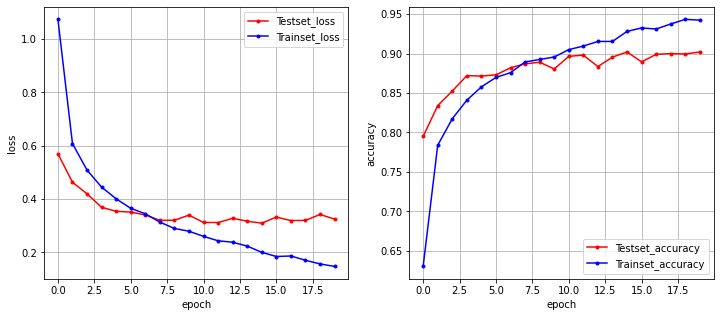

In [ ]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize = (12, 5))

# 오차
y_vloss = history.history['val_loss']

# 학습셋 오차
y_loss = history.history['loss']

# 그래프로 표현
x_len = np.arange(len(y_loss))
ax1.plot(x_len, y_vloss, marker = '.', c="red", label='Testset_loss')
ax1.plot(x_len, y_loss, marker = '.', c='blue', label = 'Trainset_loss')

# 그래프에 그리드를 주고 레이블을 표시
ax1.legend(loc='upper right')
ax1.grid()
ax1.set(xlabel='epoch', ylabel='loss')


# 정확도
y_vaccuracy = history.history['val_accuracy']

# 학습셋
y_accuracy = history.history['accuracy']

# 그래프로 표현
x_len = np.arange(len(y_accuracy))
ax2.plot(x_len, y_vaccuracy, marker = '.', c="red", label='Testset_accuracy')
ax2.plot(x_len, y_accuracy, marker = '.', c='blue', label = 'Trainset_accuracy')

# 그래프에 그리드를 주고 레이블을 표시
ax2.legend(loc='lower right')
ax2.grid()

ax2.set(xlabel='epoch', ylabel='accuracy')

# draw gridlines
ax2.grid(True)
plt.show()

### 6. 틀린 데이터 확인

분류를 하는데 어떤 것을 틀렸는지 확인해보자.

In [ ]:
y_pred = model.predict(X_val).round(2)

y_val_label = list(map(np.argmax, Y_val))
y_pred_label = list(map(np.argmax, y_pred))

우선 confusion_matrix을 통해 어떻게 분류를 했는지 확인해보자.

In [ ]:
plt.figure(figsize = (16,9))

cm = confusion_matrix(y_val_label,y_pred_label)

sns.heatmap(cm , annot = True,fmt = 'd',xticklabels = class_names,yticklabels = class_names)

이번에는 이미지를 통해 틀린것을 확인해보자.

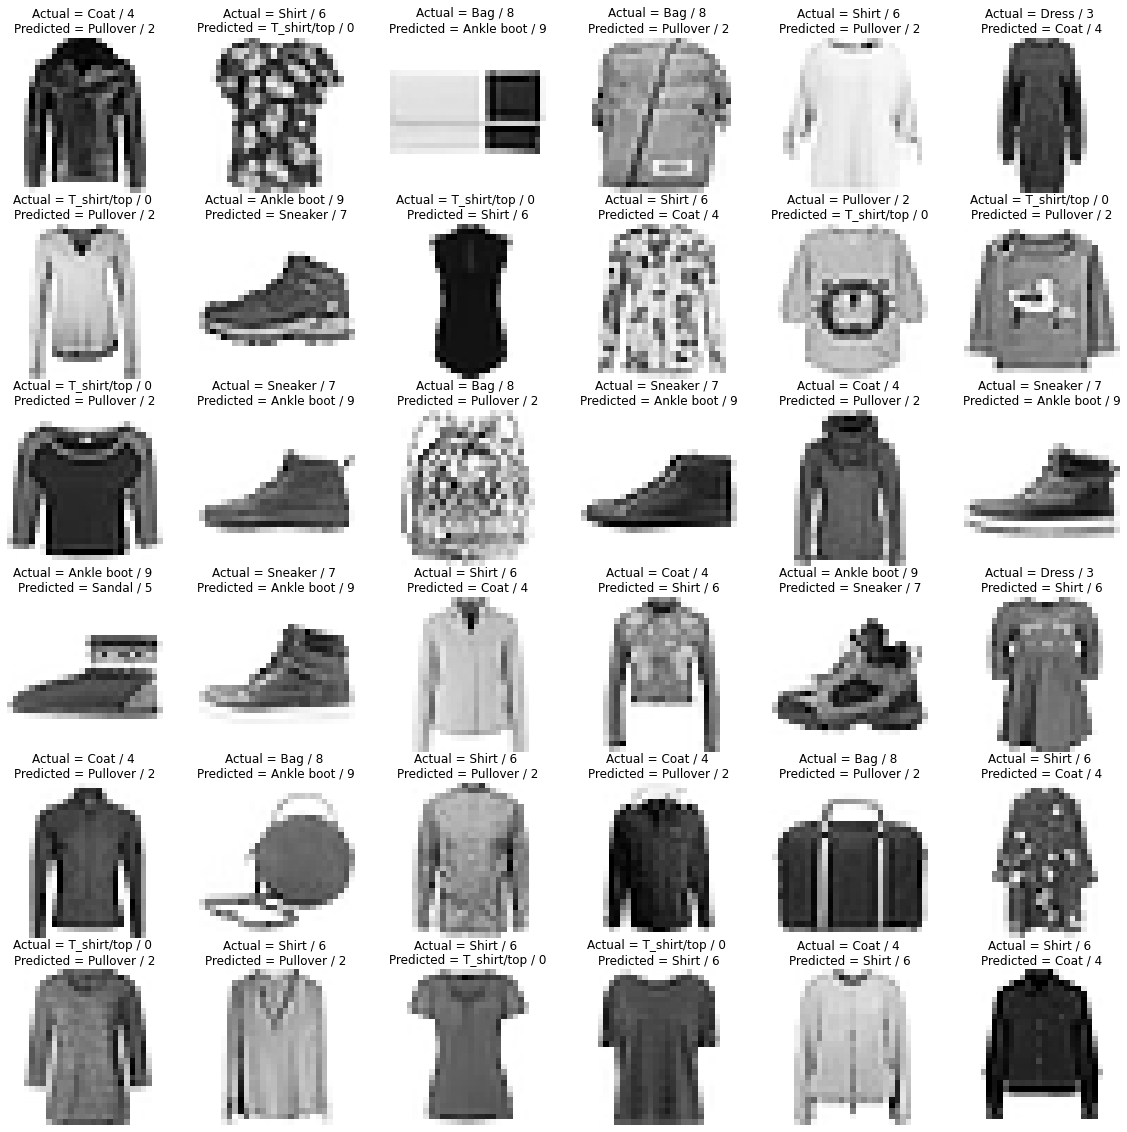

In [ ]:
aaa = np.array(y_val_label) != np.array(y_pred_label)

not_equel_list = np.where(aaa == True)[0]

plt.figure(figsize=(20,20))
j = 1
for i in not_equel_list[0:36]:
# for a in np.random.randint(0,206,36):
#     i = not_equel_list[a]
#     print(a)
    plt.subplot(6,6,j); j+=1
    plt.imshow(X_val[i].reshape(28,28),cmap = 'Greys')
    plt.axis('off')
    plt.title('Actual = {} / {} \nPredicted = {} / {}'.format(class_names[y_val_label[i]],
                                                            y_val_label[i],
                                                            class_names[y_pred_label[i]],
                                                            y_pred_label[i]))

위의 사진을 보면 shirt를 pullover로 분류 하고 ankle boot를 sneaker로 분류 한것도 있는데 사실 이부분은 나도 구분을 못하긴 하겠다.

![](https://www.kaggleusercontent.com/kf/66502306/eyJhbGciOiJkaXIiLCJlbmMiOiJBMTI4Q0JDLUhTMjU2In0..vxFbrZv0accSUXv0gAhfFQ.aJUEiIXwedVeR6ODk_fhn0AOABiSTdLx3GFOh9jkq8X-FLn-ansM1r4C47HfUoijZX5dDIVeeKk8uIl3NzW5CRClOucAhLDCyXXxVrM0AvWV3FOWvrbxUT5xQwaL4zDBwPP4Uf7YGgeEFRy_U3N3F_XsH7PVBQnJsNHVBP8vdCFmcPqx_b8htcGY5mMC37GL8Hl3hiSmcfCowl9tjWWGgih2tyHn_9L_nkAkHFFkRuc3zMoBFJYYrk3zwbel80FEqsixjvedkwT7ec0HMTD6eBXqGZ8t4sKz8DVL97q8D6aFxDiZHQ2wxzMwwBh-bzx3C1sWqMzRpgQP71Nb5J4lVAKtQYDDcH4w7pdMZNzTMwKDwwO501MiA3kGigpGy9eqIi3eeM6Z2JPDYfqgCL3rCjALeP7veVdwc3C7N2Pb2O2t7RrDuz7zHthKV6GjYKaw5PHfgkH6Aifr5z7fjo05Y9d5JgH8IaJYBBNv6ds9jtB07o5hMuetucInwVL1yNiRZGS2jNcj3AXJ8gCHsm2u5qTAQgsP3f0T2kiUnrIMIwnAmfiAkah45L1XxJCI3EgxuEQkWqlsU8dVcC6_B1l8Ohy07nweG0tLAL0taL_Tdur6YCWsZTjDYcATM_eh20MtR92ZFZEdJFEV3Y0a47yl5Um_xSpvSyj9p-AKkoKXGzc.XY_4Nuc5VIBhB2xP46Lf6Q/__results___files/__results___33_0.png)

In [ ]:
results = model.predict(test)
results = np.argmax(results,axis = 1)
results = pd.Series(results,name="Label")

In [ ]:
submission = pd.concat([pd.Series(range(1,28001),name = "ImageId"),results],axis = 1)
submission.to_csv("results_fashion_mnist.csv",index=False)

# 총평

최근에 딥러닝을 공부 하고 있다. 기초적인 mnist를 필사 하는 과정인데, 아직은 모델을 설계 하는과정에서 직관적으로 와닿지가 않지만 이는 어느정도 훈련을 해가면서 익숙해야 겠다.

---

### Reference


- Kaggle Mnist
    - [Introduction to CNN Keras - 0.997 (top 6%)](https://www.kaggle.com/yassineghouzam/introduction-to-cnn-keras-0-997-top-6)
    - [TensorFlow deep NN](https://www.kaggle.com/kakauandme/tensorflow-deep-nn)
    - [25 Million Images! [0.99757] MNIST](https://www.kaggle.com/cdeotte/25-million-images-0-99757-mnist)

- kaggle fashion
    - [How Autoencoders Work: Intro and UseCases](https://www.kaggle.com/shivamb/how-autoencoders-work-intro-and-usecases)
    - [A Simple CNN Model Beginner Guide !!!!!!](https://www.kaggle.com/pavansanagapati/a-simple-cnn-model-beginner-guide)
    - [CNN-Fashion-MNIST Image Classification](https://www.kaggle.com/lykin22/cnn-fashion-mnist-image-classification)
    - [Introduction to GANs on Fashion MNIST Dataset](https://www.kaggle.com/sayakdasgupta/introduction-to-gans-on-fashion-mnist-dataset)
    - [CNN with Keras](https://www.kaggle.com/bugraokcu/cnn-with-keras)
    - [CNN with Tensorflow|Keras for Fashion MNIST](https://www.kaggle.com/gpreda/cnn-with-tensorflow-keras-for-fashion-mnist)